In [1]:
#Kspice
import sys
sys.path.append(r"C:\Program Files (x86)\Kongsberg\K-Spice\bin64") #add to path to allow kspice import
import kspice # if import error, check correct python version (should be 3.11)

#Basic functionality
import pandas as pd
import numpy as np
import matplotlib

#ML
import torch 

#K-spice functionality
from enviroment import Sim

# Neural network
from DQN import DQN

#utilities
from utils import select_action, ReplayMemory

#train and optimize
from trainer import optimize_model, train

In [2]:
project_path = r"C:\Appl\K-Spice-Projects\Kristin_v23" #Specify path to downloaded project.
_ = kspice.Simulator(project_path) #Create instance of project

In [4]:
#This cell should contain the disabling of the power and wells modules - functionality not found in python API

# Only disable the modules, do not activate the timeline from the software as this is done in the next cell

In [5]:
timeline = _.activate_timeline("Engineering") # Select the avaliable engineering timeline
app = "Topside" # We only make changes to the topside module NOTE: From software we can #deactivate Wells and Power in ESS model, can this be done from python?
timeline.initialize() #

In [6]:
timeline.load_model("KristinMaria_master_disabledPowerWells") #Load model
timeline.load_parameters("KristinMaria_master_disabledPowerWells") # load fixed parameters
timeline.load_initial_condition("KristinMaria_master_disabledPowerWells") # Load initial conditions

In [117]:
env = Sim(timeline, app)
env.import_variables("xlsx/S23_PumpPower.xlsx")

In [118]:
for string in ["Input", "Output", "Ctrl", "Global KPI"]:
    env.check_df(string)

S23FIT1014:VolumeFlow ✓
S23FV1014:ValveStemPosition ✓
S23FIC1014:TargetSetPoint ✓
S23PA001Ap:ConsumedPower ✓


In [119]:
n_states = sum([len(env.state[i]) for i in range(len(env.state))]) # the flattened state output will be the input layer to the network
n_actions = 3 # (up, down, stay) x (up, down, stay) every combination of action is an action

In [120]:
policy_net = DQN(n_states, n_actions) # neural network (MLP)
target_net = DQN(n_states, n_actions) # To increase stability we have an additional target network which "soft updates" the weigths to the policy net.
target_net.load_state_dict(policy_net.state_dict()) #copy weights and biases

<All keys matched successfully>

In [143]:
memory = ReplayMemory(100)

In [122]:
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_results(consumptions, rewards, losses):
    fig, axs = plt.subplots(3, sharex=True, figsize = (19, 8))

    axs[0].plot(consumptions, 'o-', color = 'C0', linewidth = 0.5, label = "Global KPI")
    axs[0].legend(loc="upper right")

    axs[1].plot(rewards, marker = 'o', color = 'C1', linewidth = 0, label = "Reward")
    axs[1].legend(loc="upper right")

    axs[2].plot(losses, 'o-', color = 'C4', linewidth = 0.5, label = "Loss")
    axs[2].legend(loc="upper right")


    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(1)

In [127]:
BATCH_SIZE = 2 # number of transitions sampled from the replay buffer
GAMMA = 0.99 # The factor in the discounted cumulative reward, we care about the rewards in the future but with a discount factor gamma. 
TAU = 0.005 # The target network should change slowly to improve stability - hence a soft update, with the TAU factor, of the target weights is used.  
LR = 1e-4 #Learing rate of optimizer

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [142]:
import sys
del sys.modules['utils'] #to delete package memory - loading updates of Sim class
del sys.modules["trainer"]
from trainer import train
from utils import ReplayMemory

In [135]:
env.timeline.set_speed(100)

100.0

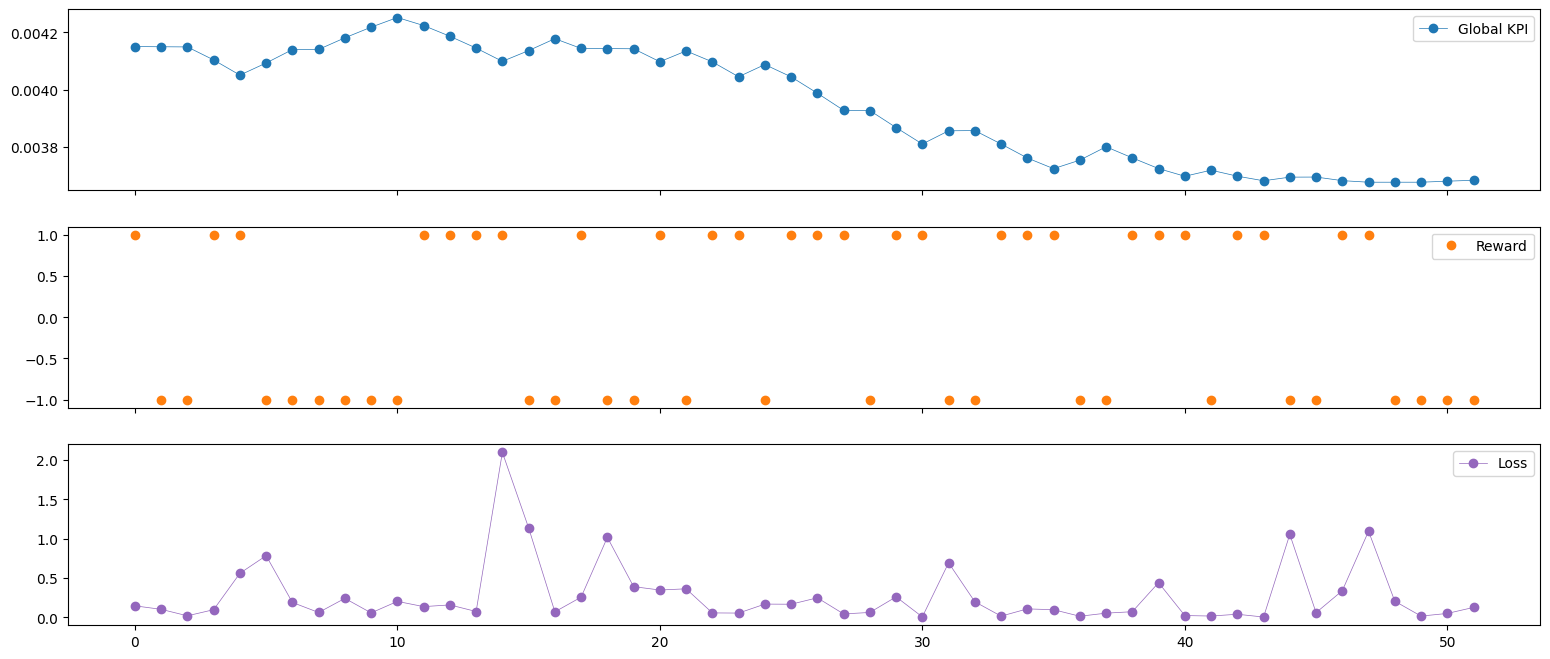

In [ ]:
train(env, policy_net, target_net, memory, optimizer, plot_results, BATCH_SIZE, GAMMA, TAU)